# Model evaluation

So far our model evaluation was relatively simplistic, using a split into training and test data as shown in Figure TODO.

![:scale 100%](images/train_test_split_new.png)

This is a common scheme, but has several limitations that we'll address now.
The first issue is model selection. As we discussed before, many models have hyper-parameters that we need to specify, such as ``k_neighbors`` in the ``KNeighborsClassifier``.
We also might want to choose between different families of models or different algorithms. For simplicity, let's focus on the case of a single hyper-parameter, but there's no difference between that and selecting a different algorithm in principle.
A natural way to find a good parameter to use would be to try different values, i.e. fit a model for each value of the hyper-parameter on the training set, and evaluate it on the test set.
It seems that the hyper-parameters performing best on the test set should be a good choice. That's true, however, with a caveat that's illustrated in figure TODO.
![:scale 80%](images/overfitting_validation_set_3.png)

todo explain figure more; should say test set in the figure?

The figure assumes we know what the "real" generalization performance of each hyper-parameter setting would be, a quantity that's only theoretically knowable, but the quantity that we're actually interested. What we have is the performance on the test set, which can be understood as a noisy version of the true generalization ability of the model.
Now if we pick the best performing hyper-parameters, as indicated by the red dot, it provides a good estimate of what the optimum hyper-parameter value should be, in other words on the x-axis, the red dot is close to the maximum of the idealized generalization performance (the orange line).
However, because we took the maximum of a noisy value, the actual accuracy at this point, i.e. the y axis value of the red dot, is overly optimistic. While the test set accuracy is an unbiased estimate of generalization, i.e. it's unbiased on average, taking the maximum over all hyper-parameters results in an optimistic bias.

```{note} Bias in validation and multiple testing
The issue described above of using the test set both for finding the optimum hyper-parameters and for estimating the accuracy of these parameters can be linked to the concept of multiple testing errors in statistics.
The underlying idea is that if I try out many different things (say many hypothesis or many hyper-parameters), then at some point, I'll get a 'good' result by accident. In a process involving randomness and uncertainty, trying 100 times and getting a good result is not the same as trying once and getting a good result. Luckily the fix for our issue is much easier than the fix for multiple hypothesis testing.
```

So while we now know a good setting for our hyper-parmeter, we have no way of estimating how well the model with this hyper-parameter actually performs. If we want to use this model in production, that's a pretty big issue.
However, it has a pretty simple solution: using an additional hold-out set, as shown in Figure todo.

## The Threefold-split

![:scale 100%](images/train_test_validation_split.png)

This use of three separate sets, a training set for model building, a validation set for model selection, and a test set for final model evaluation, is probably the most commonly used method for model selection and evaluation, and (apart from some modifications that we'll discuss below), it's a best practice that you should use whenever possible. The result is illustrated in Figure todo.
![:scale 80%](images/overfitting_validation_set_4.png)

We now use the validation set to find the value (i.e. x-axis location) of the optimum hyper-parameter, and the test set to find the corresponding y-value. Because we haven't used the test set for estimating the best hyper-parameter, the test set provides an unbiased estimate of generalization performance when following this method.
One aspect of this is critically important, though: the test set only provides an unbiased result if we are using it once. We apply this selection procedure several times, compare several test-set results, and pick the best-performing model, we end up with the situation we started with, and our estimate will be biased. Therefore, **you should be really careful in when to use the test set**, and ideally set it aside and **use it only once, after you decided on the final model you want to use**.

[Preventing Overfitting in cross-validation - Ng 1997](20http://robotics.stanford.edu/~ang/papers/cv-final.pdf)]

## Implementing the threefold split
Before we go into more detail of tools for doing model-evaluation with scikit-learn, let's do the procedure *by foot* first, to clarify the process.
Here is a simple implementation of using the three-fold split strategy for selecting the number of ``n_neighbors`` in ``KNeighborsClassifier`` on the TODO iris dataset.
We split our dataset into three parts, by first talking 25% as the test set, and then taking 25% of the remainder as validation set (so about 19% of the original data).
Then we define the candidate values of the parameter we want to adjust. This often requires knowledge of the algorithm and potentially the dataset.
Here, we're using a range from 1 to 14 in steps of 2. For ``n_neighbors``, often uneven numbers are used to avoid ties. The upper range is picked somewhat arbitrarily, but we certainly wouldn't want to use more than 50, the number of samples in each class in this dataset.

```{margin} Grid Search
The process of trying every value of interest is often called **grid search** in the machine learning context, and basically constitutes a brute-force search for the optimum value.
The name grid search stems from the fact that when searching over multiple hyper-parameters, usually all possible combinations are tried, which corresponds to a grid of hyper-parameters.
```

Then, we build a model for each value of ``n_neighbors`` in our list, evaluate it on the validation set, and store the result. Finally, we find the value that gave us the best result.

Now we have basically made it to computing the red dot in figure TODO, and we only need to evaluate the purple dot.
The easiest way to do this would be to just predict on the test set, which is certainly possible. In partice, we often prefer rebuilding the model using the training data together with the validation data.
After we found the best value of ``n_neighbors`` the validation set is no longer useful, and so we can just use it as more data to build our model with. So we train a new model, using the best value of ``n_neighbors`` as determined by the validation set, use as training data both the original training set and the validation set, and evaluate the model on the test set.
This provides us with an unbiased estimate of how well this final model will generalize.

The step of retraining a model using both the training and validation set is optional, and if model training is very expensive, or we can assume the training dataset is large enough for our model, we might skip this step. Here, we have very little data, however, and we should use as much as we can get. We'll also see more reasons to use this retraining technique later.

In [9]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# Load the data and split it into three parts
X, y = load_iris(return_X_y=True)
# first split off test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=23)
# then split of validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=23)

# create a list to hold validation scores for each
# hyper-parameter setting
val_scores = []
# Specify a list of values we want to try for n_neighbors
# This might require some knowledge of the dataset and the model
# or potentially some trial-and-error
neighbors = np.arange(1, 15, 2)
# for each potential value of n_neighbors
for i in neighbors:
    # build a model
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    # score validation set accuracy
    val_scores.append(knn.score(X_val, y_val))
# using max tells us the best score
print(f"best validation score: {np.max(val_scores):.3}")
# with argmax we can find the best value of n_neighbors used
best_n_neighbors = neighbors[np.argmax(val_scores)]
print("best n_neighbors:", best_n_neighbors)
# Now,
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_trainval, y_trainval)
print(f"test-set score: {knn.score(X_test, y_test):.3f}")

best validation score: 1.0
best n_neighbors: 3
test-set score: 0.974


Using a three-fold split into training, validation and test set is essential whenever you're evaluating more than one model-which is always.
However, there's another aspect we might want to improve, which is the reliance on the particular splits.
If we change the random state in the splitting (todo?) we might end up with different results. Ideally we want the parameters we pick and our assessment of generalization ability not to be impacted by
the initial splitting of the data. In fact, having large variety between outcomes depending on the data split is probably a bad sign and means our model is not very robust.
In some cases, when the data is particularly small, such as for the iris dataset that we're using here, this can be hard to overcome, but there's still one tool
that's invaluable to have in your toolbox to make model evaluation more robust: cross-validation.

## K-Fold Cross-validation
The idea of cross-validation is to replace the split into training and validation data by multiple different splits.
In general, you can think of cross-validation as a method for splitting data into two parts repeatedly; most commonly
it is applied to the training/validation split, but it could also be applied to splitting off the test data.

![:scale 80%](images/cross_validation_new.png)

```{margin} Splitting strategies
There are many other splitting strategies that we'll discuss in chapter todo. For now, let's stick to 5-fold or 10-fold cross-validation.
```

The most common variant of cross-validation is called k-fold cross validation and illustrated in figure todo.
The first step is to split the data into k disjoint parts, often $k=5$ or $k=10$, which are called folds, usually of about equal size.

```{margin} todo
Max uses the word fold differently
```

For each fold, a split of the data is made where this fold serves as validation data (TODO label in image), and the rest of the data serves as training data,
as illustrated in Figure TODO. This means if we use 5-fold cross-validation, we will split our data into five parts,
and then have five different training/validation splits. We build a model for each of these splits of the data, using the training part do build the model,
and the validation part to evaluate it. The outcome is (in the case of five folds) five different accuracy values.
We can then aggregate these and compute a mean or median, or use them to estimate the variance over the different splits.

The benefit over using a single split is that the method is more robust; each data point in the initial dataset is in the validation set exactly once,
while with a single split, only some of the data appears in the validation data. This reduces the variance of the accuracy measurement that is produced.
Using cross-validation can also potentially lead to a more effective use of data: when using five-fold cross-validation, each split can use 80% of the data as training set,
and when using ten-fold cross-validation, it's even 90%. Still, all of the data is used as validation data in exactly one of the splits.

The main disadvantage of using cross-validation is the computational cost; five-fold cross-validation requires building five models on 80% of the data, so it's about 5 times slower than using a single split.
The other, potentially less drastic disadvantage is that k-fold cross-validation doesn't produce a model, it produced k models. If you want to make predictions on new data, it's somewhat unclear how to do this.
The most obvious choice is retraining on the whole dataset, as we did above, but there are other solutions, which we'll discuss in chapter todo.

### Cross-validation with scikit-learn
There are two functions in ``scikit-learn`` that you can use to perform cross-validation, the ``cross_val_score`` function and the ``cross_validate`` function. The ``cross_val_score`` function has been in scikit-learn for a long time and has a very simple interface, while the ``cross_validate`` function was added later, is a bit more powerful and provides more options. However, they have a very similar interface, and are easy to use. Let's apply them to evaluating ``KNeighborsClassifier`` on the ``iris`` dataset. As I mentioned above, cross-validation is usually used to replace the inner split into training and validation set, and so we'll apply it on ``X_trainval`` and ``y_trainval`` from TODO.
Both functions, ``cross_validate`` and ``cross_val_score`` take the estimator you want to evaluate, so in our case ``KNeighborsClassifier``, the data, for us ``X_trainval``, the target ``y_trainval`` and optionally the number of folds to use, say 5 or 10.
The result of ``cross_val_score`` is simply an array with one entry per split, corresponding to the accuracy on the particular validation set:

In [12]:
from sklearn.model_selection import cross_val_score, cross_validate
# cv=10 uses ten-fold cross-validation
scores = cross_val_score(KNeighborsClassifier(), X_trainval, y_trainval, cv=10)
scores

array([0.91666667, 0.91666667, 0.90909091, 0.90909091, 1.        ,
       0.90909091, 1.        , 1.        , 1.        , 0.90909091])

Now let's try ``cross_validate``. The result of ``cross_validate`` is a dictionary, though it's easier to display if we convert it to a pandas DataFrame:

In [16]:
import pandas as pd
# we could pass cv here as well, but we're using the default of 5
cv_result = cross_validate(KNeighborsClassifier(), X_trainval, y_trainval)
pd.DataFrame(cv_result)

,fit_time,score_time,test_score
0,0.0,0.001995,0.913043
1,0.0,0.001995,0.913043
2,0.0,0.001995,0.954545
3,0.0,0.000997,1.000000
4,0.0,0.000995,0.954545


In [ ]:
As you can see, the result also contains the time it took to fit the model and make the predictions. We can also compute the training set accuracy, which can be helpful for assessing model complexity:

In [17]:
cv_result = cross_validate(KNeighborsClassifier(), X_trainval, y_trainval, return_train_score=True)
pd.DataFrame(cv_result)

,fit_time,score_time,test_score,train_score
0,0.000191,0.001017,0.913043,0.966292
1,0.000998,0.000997,0.913043,0.955056
2,0.000000,0.000998,0.954545,0.977778
3,0.000000,0.000997,1.000000,0.955556
4,0.000000,0.000997,0.954545,0.966667


We can even return the fitted estimated if we like:

In [19]:
cv_result = cross_validate(KNeighborsClassifier(), X_trainval, y_trainval, return_estimator=True)
pd.DataFrame(cv_result)

,fit_time,score_time,estimator,test_score
0,0.000000,0.001995,KNeighborsClassifier(),0.913043
1,0.000000,0.001019,KNeighborsClassifier(),0.913043
2,0.000996,0.000999,KNeighborsClassifier(),0.954545
3,0.000976,0.000998,KNeighborsClassifier(),1.000000
4,0.000000,0.001994,KNeighborsClassifier(),0.954545


Both, ``cross_val_score`` and ``cross_validate`` can compute other evaluation metrics, not only accuracy. We'll discuss that in detail in chapter TODO.

## Grid-Search with Cross-Validation
Now let's come back to doing model selection as we did in todo, but this time we're using cross-validation instead of a single split. The overall idea is illustrated in Figure todo.
We still keep the initial split into training and test set, but then, instead of using a single split into training and validation set, we run cross-validation for each parameter setting.
We then record the mean score, where the mean is averaged over the k (here 10) splits in the cross-validation. After we evaluated all candidate parameters, we find the one with the best mean accuracy.
Keep in mind that this score does not correspond to a single model; there is no best model here. What we select is the hyper-parameter that's best **on average** over the 10 splits.
Then we build a new model, using the hyper-parameters that performed best on average in cross-validation, on the full training dataset (called X_trainval below).
Finally, we evaluate this model on the test dataset.

```{margin}
todo should it be X_train or X_trainval?
```

![](images/grid_search_cross_validation_new.png)


In [22]:
# We split our data into only two parts
# Usually we'd call these X_train and X_test
# We use X_trainval to emphasize that it takes the same role as X_trainval above
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=23)

cross_val_scores = []
# again we define our candiate values
neighbors = np.arange(1, 15, 2)

for i in neighbors:
    # we define the model with hyper-parameters
    knn = KNeighborsClassifier(n_neighbors=i)
    # Instead of fitting a single model, we perform cross-validation
    # fitting 10 models, and returning 10 scores
    scores = cross_val_score(knn, X_trainval, y_trainval, cv=10)
    # we record the average score over the 10 folds
    cross_val_scores.append(np.mean(scores))

# We can compute the best mean score
print(f"best cross-validation score: {np.max(cross_val_scores):.3}")
# and corresponding best parameters
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]
print(f"best n_neighbors: {best_n_neighbors}")

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_trainval, y_trainval)
print(f"test-set score: {knn.score(X_test, y_test):.3f}")

best cross-validation score: 0.974
best n_neighbors: 13
test-set score: 1.000


Using this combination of brute-force grid-search with cross-validation and a hold-out test set is a gold standard method for model comparison and parameter tuning in machine learning.
The main downside of this procedure it it's computational cost: the above example tries seven different values for ``k_neighbors``, each on ten different splits of the data, plus a final model, meaning we build 71 models in total during this process.
If we had another hyper-parameter, say with 5 different values of interest, we would typically try all possible combinations, leasing to 351 models being build!


```{note}
One of my biggest pet-peeves in machine learning is people conflating the use of cross-validation with the use of grid search
These are very distinct concepts and shouldn't be used interchangeably: cross-validation is a technique to robustly evaluate a particular model on a particular dataset. In essence, it's a slightly more robust version of just splitting your data into two sets. Grid-search is a technique to tune the hyper-parameters of a particular model by brute-force search. Often each candidate is evaluated using cross-validation, though that's not necessary. You could also evaluate each candidate with a single split into training and validation set, for example.
So while cross-validation is often used within a grid search, you can also do cross-validation outside of a grid search, and you can do a grid search without using cross-validation.
```

The overall process is illustrated in figure TODO. We start off by specifying the hyper-parameters (todo figure parameters) we want to evaluate, which in principle can also include which model we are using.
We split our dataset into training and test set. For each hyper-parameter candidate, we run grid-search on the training set, which yields a score for each split, and a mean score over all the splits.
Using the mean validation scores, we select the best hyper-parameter value, and retrain a model on the whole training data. Then, we evaluate this final model on the test dataset.

![:scale 80%](images/gridsearch_workflow.png)


Because this is such a common pattern, there is a helper class for this
in scikit-learn, called GridSearchCV, which does most of these steps
for you.

## GridSearchCV
The ``GridSearchCV`` class is another meta-estimator, that can take any scikit-learn model and tune hyper-parameters for you using cross-validation.
Here is the example from todo using GridSearchCV. The hyper-parameter grid is specified as a dictionary, where the keys are the names of the parameters in the estimator (here the single hyper-parameter ``n_neighbors``) and the values are all the candidate values of the hyper-parameter that we want to evaluate. The ``GridSearchCV`` class is then estimated with the estimator we want to tune and the hyper-parameter dictionary. We can also specify how to perform cross-validation (``cv=10``) and we will compute the training scores for evaluation purposes.

In [23]:
from sklearn.model_selection import GridSearchCV
# split the data as before
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
# define the parameter grid, key must be exactly the same as name of the parameter
param_grid = {'n_neighbors':  np.arange(1, 15, 2)}
# Instantiate GridSearchCV - this sets up the grid-search
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10,
                   return_train_score=True)
# Calling fit executes the search and retrains the final model
grid.fit(X_train, y_train)
# show some information on the search:
print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameters: {grid.best_params_}")
# do the final evaluation
print(f"test-set score: {grid.score(X_test, y_test):.3f}")

best mean cross-validation score: 0.9643939393939392
best parameters: {'n_neighbors': 5}
test-set score: 0.895


```{margin}
The distinction between the test set score and the ``best_score_`` attribute is a bit subtle but important: The ``best_score_`` is an average cross-validation score, and it is optimistic, as illustrated in Figure todo. The test-set score is an unbiased estimate, but only as long as you don't use it to select a model.
```
You can see that the whole process is quite simple using ``GridSearchCV``. The great thing about grid search being implemented as a meta-estimator is that after you instantiated the ``GridSearchCV`` object, you can use it like any other scikit-learn model: it has the standard interface of ``fit``, ``predict`` and ``score`` which will use the model that was retrained using the best hyper-parameter setting. St this point you don't need to worry about the fact that it is tuning parameters internally.
However, given that we should only reserve the test-set for a final evaluation, it can be a good idea to look at the search results before using the test set. The attribute ``best_score_`` contains the mean validation score over all splits of the best hyper-parameter setting, and the best hyper-parameter is stored in ``best_params_``.
If the ``best_score_`` is lower than what you expected or what you need for your application, there is no point in using the test set, as the mean score will be an optimistic estimate, as discussed above todo.
One aspect you might want to look into for the best parameter is whether it is on the boundary of the search space you specified. If the best value found is at the edge of the values I tried, maybe the true optimum is outside the range and I should extend the range.
We can look into the results in even more detail using the ``cv_results_`` attribute, which is a dictionary with a structure somewhat similar to the result of ``cross_validate``. However, in ``cv_results_``, each row corresponds to a hyper-parameter setting, and contains the scores for all the splits:

In [25]:
# cv_results_ is a dict, but DataFrames are nicer
results = pd.DataFrame(grid.cv_results_)
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'split5_train_score', 'split6_train_score',
       'split7_train_score', 'split8_train_score', 'split9_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [28]:
results.params

0     {'n_neighbors': 1}
1     {'n_neighbors': 3}
2     {'n_neighbors': 5}
3     {'n_neighbors': 7}
4     {'n_neighbors': 9}
5    {'n_neighbors': 11}
6    {'n_neighbors': 13}
Name: params, dtype: object

```{margin} TODO
Should we use cv=5 to print less ehere?
```

Each column has the mean accuracy scores for the test set and training set (as we specified ``return_train_score=True``), as well as the individual score for each split.
If we have a single hyper-parameter, the result can be nicely visualized using a line-plot. One way is to show the mean and standard deviation:

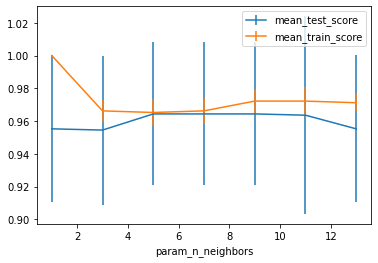

In [37]:
import matplotlib.pyplot as plt
# we use std for error bars.
# Some people might perfer the 95% confidence interval or the standard error of the mean
ax = results.plot('param_n_neighbors', 'mean_test_score', yerr='std_test_score')
# reuse the axes from the first plot (ax=ax)
results.plot('param_n_neighbors', 'mean_train_score', yerr='std_train_score', ax=ax)
plt.legend()

As you can see, there is quite a wide standard deviation on the validation sets in the different splits, which is somewhat unsuprising given the small size of the dataset.
We can also visualize each split as an individual curve, which might make trends easier to spot (though you shouldn't read too much into these results - this is the iris dataset after all):

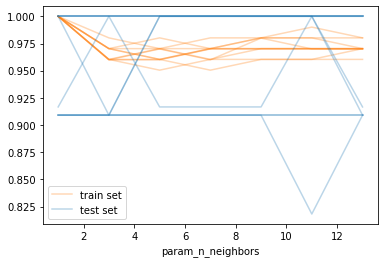

In [71]:
# list all the columns for train scores and test scores respectively
# easier to just generate them instead of trying to slice them or match them
test_score_cols = [f"split{i}_test_score" for i in range(10)]
train_score_cols = [f"split{i}_train_score" for i in range(10)]

ax = results.plot(x='param_n_neighbors', y=train_score_cols, c='tab:orange', alpha=.3) 
results.plot(x='param_n_neighbors', y=test_score_cols, c='tab:blue', alpha=.3, ax=ax) 

# Get lines for the legend. This is a bit hacky
# but better than having 20 entries in the legend
train_line = ax.get_children()[0]
test_line = ax.get_children()[10]

plt.legend([train_line, test_line], ["train set", "test set"])

````{margin} CAVEAT TODO Move to model evaluation chapter
The result of
```python
grid.predict(X_test, y_test)
```
and
```python
grid.best_estimator_.predict(X_test, y_test)
```
is always identical.
However, the result of
```python
grid.score(X_test, y_test)
```
and
```python
grid.best_estimator_.score(X_test, y_test)
```
is not, as the first uses the metric used in GridSearchCV, while the second uses the score method of the best estimator (i.e. accuracy or R^2).
````

### The `best_estimator_`
There is another attribute of ``GridSearchCV`` that is commonly used, though maybe used too much, which is called ``best_estimator_``. This attribute stores the model that was refit on the whole training data, and is the model that is used when calling ``predict`` and ``score``. For most use-cases, you can just call ``predict`` and ``score`` on the ``GridSearchCV`` object directly, and there is no need to use the ``best_estimator_`` attribute. However, if you want to access specific attributes of the models, say coefficients in a linear model, you can do that using ``best_estimator_``.

## Nested Cross-Validation
As mentioned above, it's most common to use cross-validation for the training/validation part of the training/validation/test split.
However, we can also use it for both splits, which results in what is known as *nested cross-validation*.
Nested cross-validation is easy to implement with scikit-learn, but not commonly used, for three reasons:
- It's computationally expensive as it adds another for-loop to the grid-search process.
- It doesn't result in a single model, as cross-validation doesn't produce a single model, and so it's hard to productionize.
- It's conceptually somewhat hard to understand what it computes.

The first of these should be quite clear: imagine we add an outer cross-validation loop to the example of todo. This would be expressed with scikit-learn like this:

In [76]:
# note that we don't call train_test_split
param_grid = {'n_neighbors':  np.arange(1, 15, 2)}
# instantiate grid search
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10,
                   return_train_score=True)
# perform cross-validation on the grid-search estimator
# where each individual fit will internally perform cross-validation
res = cross_validate(grid, X, y, cv=5, return_train_score=True, return_estimator=True)

In [77]:
pd.DataFrame(res)

,fit_time,score_time,estimator,test_score,train_score
0,0.262298,0.000998,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",0.966667,0.975000
1,0.255318,0.001002,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",1.000000,0.966667
2,0.256428,0.000997,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",0.933333,0.966667
3,0.254881,0.000993,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",0.966667,0.983333
4,0.250332,0.000997,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",1.000000,0.966667


Before, we had 7 hyper-parameter settings, and 10 cross-validation folds, plus a final evaluation, leading to 71 models being build.
If we use five-fold cross-validation on this whole process, this will mean we're building 355 models, which will clearly take much longer.

Also, the outcome is now five different scores, one for each split. However, these don't correspond to a particular model, as within this outter loop, grid-search led to different optimum parameters:


In [79]:
[x.best_params_ for x in res['estimator']]

[{'n_neighbors': 9},
 {'n_neighbors': 7},
 {'n_neighbors': 3},
 {'n_neighbors': 7},
 {'n_neighbors': 11}]

So we don't end up with a model we can immediately use on new data. One way to get around this is to make predictions from each individual GridSearchCV model, and average the results TODO is this good here?, but that results in a somewhat complicated and hard-to-understand model.

Finally, it's a bit hard to grasp what the result of the grid-search represents. It is an estimate of how well a given model generalizes if the hyper-parameters are adjusted with grid search. This can be interesting when comparing algorithms while taking into account hyper-parameter tuning: "Is algorithm A better than algorithm B on this dataset if both are properly tuned?". It can also be useful for seeing if there is signal in the data at all in settings where the dataset is very small todo cite Gael?

However, for most every-day data science use-cases, the workflow illustrated in figures todo and todo is likely better suited for your needs.

## Summary
Selecting hyper-parameters and selecting between different models is a cruicial component of building successful machine learning models. However, comparing models naively on the test set can lead to overly optimistic expectations about the generalization ability of a model. Therefore, it's critical to use a three-step process of training, validation and testing on separate subsets of the data. This can be achieved either by splitting the data into disjoint training, validation and test set, which is quite efficient but dependant on the particular split of the data, or by using cross-validation instead of a single split for the training/validation split.
Cross-validation is more robust but also more time-consuming than using single splits.
Cross-validation is often combined with the brute-force grid-search approach to tuning hyper-parmeters, which can be easily implemented in scikit-learn using ``GridSearchCV``.